# Config

In [1]:
from __future__ import print_function
from pyspark import SparkContext , SparkConf
import sys
from operator import add
from csv import reader
from pyspark.sql import SQLContext, SparkSession
import numpy as np

In [2]:
from pyspark.sql.functions import col, lit, when, signum, avg, count, sum, round, abs

In [3]:
from matplotlib import pyplot as plt

In [22]:
from scipy.special import softmax
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [5]:
cf = SparkConf()
cf.set("spark.submit.deployMode","client")

sc = SparkContext.getOrCreate(cf)

spark = SparkSession.builder.appName("Analysis_RDS").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 22:16:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/11 22:16:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/11 22:16:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/11 22:16:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


# Top-5 league comparison 2015/16 season   

In [16]:
#Data cohort for consideration
leagues = ['La Liga','Premier League','Serie A','Ligue 1','1. Bundesliga']
season = '2015/16'
season_id = 27
gender = 'male'

In [6]:
filepath = 'Project/Data/Format_data/matches.parquet'
df_matches_data = spark.read.parquet(filepath)
df_matches_data.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [7]:
filepath = 'Project/Data/Format_data/competitions.parquet'
df_comp_data = spark.read.parquet(filepath)
df_comp_data.printSchema()

root
 |-- competition_gender: string (nullable = true)
 |-- competition_id: long (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- competition_name: string (nullable = true)
 |-- competition_youth: boolean (nullable = true)
 |-- country_name: string (nullable = true)
 |-- match_available: string (nullable = true)
 |-- match_available_360: string (nullable = true)
 |-- match_updated: string (nullable = true)
 |-- match_updated_360: string (nullable = true)
 |-- season_id: long (nullable = true)
 |-- season_name: string (nullable = true)



In [13]:
new_data_dir = '/user/dc5415_nyu_edu/Project/Data/Format_data/'

In [17]:
df_comp_focus = df_comp_data.filter((col('competition_name').isin(leagues)) &
                   (col('season_id')==season_id))

In [18]:
## Getting all matches based on the competition in focus

condition = [(df_matches_data.competition_competition_id == df_comp_focus.competition_id) &
             (df_matches_data.season_season_id == df_comp_focus.season_id)]
df_match_focus = df_matches_data.join(df_comp_focus, on = condition,how= 'right')

In [19]:
df_match_focus.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [20]:
df_match_focus.count()

1823

In [21]:
df_match_focus = df_match_focus.withColumn('win_team_id',
                                           when(col('away_score')>col('home_score'),col('away_team_away_team_id')).\
                                           when(col('away_score')<col('home_score'),col('home_team_home_team_id')).\
                                           otherwise(-1))

df_match_focus = df_match_focus.withColumn('lose_team_id',
                                           when(col('away_score')>col('home_score'),col('home_team_home_team_id')).\
                                           when(col('away_score')<col('home_score'),col('away_team_away_team_id')).\
                                           otherwise(-1))

df_match_focus = df_match_focus.withColumn('if_draw',col('away_score')==col('home_score'))

In [13]:
df_match_focus.groupby(col('competition_competition_name'),col('if_draw')).count().show()

+----------------------------+-------+-----+
|competition_competition_name|if_draw|count|
+----------------------------+-------+-----+
|               1. Bundesliga|   true|   71|
|                     Ligue 1|  false|  269|
|              Premier League|  false|  273|
|               1. Bundesliga|  false|  235|
|                     Serie A|  false|  285|
|                     Serie A|   true|   95|
|                     La Liga|   true|   92|
|                     Ligue 1|   true|  108|
|              Premier League|   true|  107|
|                     La Liga|  false|  288|
+----------------------------+-------+-----+



## Pass analysis

In [22]:
event = 'pass'
filename = f'{new_data_dir}event_{event}.parquet'
df_pass = spark.read.parquet(filename)

df_pass = df_pass.withColumn('Passxlength',col('pass_end_location')[0]-col('location')[0])

df_pass = df_pass.withColumn('PassType',when((col('play_pattern_id')==6)|
                                                (abs(col('Passxlength'))>70),'Transition').\
                             when(col('pass_angle')>0,'Attacking').\
                            when(col('pass_angle')<0,'Defensive').otherwise('Neutral'))
                    

df_pass = df_pass.withColumn('PassOffside',when((col('pass_outcome_id')==76),True).otherwise(False))
df_pass.printSchema()

root
 |-- pass_aerial_won: boolean (nullable = true)
 |-- pass_angle: double (nullable = true)
 |-- pass_assisted_shot_id: string (nullable = true)
 |-- pass_body_part_id: long (nullable = true)
 |-- pass_body_part_name: string (nullable = true)
 |-- pass_cross: boolean (nullable = true)
 |-- pass_cut_back: boolean (nullable = true)
 |-- pass_deflected: boolean (nullable = true)
 |-- pass_end_location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- pass_goal_assist: boolean (nullable = true)
 |-- pass_height_id: long (nullable = true)
 |-- pass_height_name: string (nullable = true)
 |-- pass_inswinging: boolean (nullable = true)
 |-- pass_length: double (nullable = true)
 |-- pass_miscommunication: boolean (nullable = true)
 |-- pass_no_touch: boolean (nullable = true)
 |-- pass_outcome_id: long (nullable = true)
 |-- pass_outcome_name: string (nullable = true)
 |-- pass_recipient_id: long (nullable = true)
 |-- pass_recipient_name: string (nullable = true

In [23]:
df_pass.groupby('PassType').count().show()

+----------+-------+
|  PassType|  count|
+----------+-------+
| Attacking|1518873|
|Transition|  42176|
|   Neutral|  21048|
| Defensive|1538014|
+----------+-------+



In [24]:
df_pass.groupby('PassOffside').count().show()

+-----------+-------+
|PassOffside|  count|
+-----------+-------+
|       true|  13327|
|      false|3106784|
+-----------+-------+



In [25]:
df_pass_off_agg = df_pass.groupby(col('match_id'),col('team_id'),col('team_name')).agg(sum(when(col('PassOffside'),1).\
                                                                                                  otherwise(0)).alias('pass_offside_count'))

df_pass_off_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- pass_offside_count: long (nullable = true)



In [26]:
df_pass_agg = df_pass.groupby(col('match_id'),col('team_id'),col('team_name')).pivot('PassType').agg(round(avg(col('pass_length')),2).alias('avg_pass_distance'),
                                                                                                    round(sum(col('pass_length')),2).alias('sum_pass_distance'),
                                                                                                     count('pass_length').alias('pass_count'))

df_pass_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- Attacking_avg_pass_distance: double (nullable = true)
 |-- Attacking_sum_pass_distance: double (nullable = true)
 |-- Attacking_pass_count: long (nullable = true)
 |-- Defensive_avg_pass_distance: double (nullable = true)
 |-- Defensive_sum_pass_distance: double (nullable = true)
 |-- Defensive_pass_count: long (nullable = true)
 |-- Neutral_avg_pass_distance: double (nullable = true)
 |-- Neutral_sum_pass_distance: double (nullable = true)
 |-- Neutral_pass_count: long (nullable = true)
 |-- Transition_avg_pass_distance: double (nullable = true)
 |-- Transition_sum_pass_distance: double (nullable = true)
 |-- Transition_pass_count: long (nullable = true)



In [27]:
df_pass_agg = df_pass_agg.withColumn('total_pass_count',col('Attacking_pass_count')+col('Transition_pass_count')+
                                     col('Defensive_pass_count')+col('Neutral_pass_count'))

df_pass_agg = df_pass_agg.withColumn('attack_pass_share',col('Attacking_pass_count')/col('total_pass_count'))
df_pass_agg = df_pass_agg.withColumn('transition_pass_share',col('Transition_pass_count')/col('total_pass_count'))

df_pass_agg = df_pass_agg.withColumn('defense_pass_share',col('Defensive_pass_count')/col('total_pass_count'))

## Carry analysis

In [28]:
event = 'carry'
filename = f'{new_data_dir}event_{event}.parquet'
df_carry = spark.read.parquet(filename)

# df_carry = df_carry.withColumn('carryType',when(col('carry_angle')>0,'Attacking').\
#                             when(col('carry_angle')<0,'Defensive').otherwise('Neutral'))
df_carry.printSchema()

root
 |-- carry_end_location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: double (containsNull = tru

In [29]:
df_carry = df_carry.withColumn('CarryDirection',when(col('play_pattern_id')==6,'Transition').\
                               when(col('carry_end_location')[0]>col('location')[0],'Forward').\
                              when(col('carry_end_location')[0]<col('location')[0],'Backward').otherwise('Neutral'))

df_carry = df_carry.withColumn('CarryDistance',((col('carry_end_location')[0]-col('location')[0])**2+
                              (col('carry_end_location')[1]-col('location')[1])**2)**0.5)

df_carry.select('CarryDistance').describe().show()

+-------+------------------+
|summary|     CarryDistance|
+-------+------------------+
|  count|           2415303|
|   mean| 5.837707971996197|
| stddev| 7.089627985387496|
|    min|               0.0|
|    max|112.21853679316978|
+-------+------------------+



In [30]:
df_carry_agg = df_carry.groupby(col('match_id'),col('team_id'),col('team_name')).pivot('CarryDirection').agg(count('CarryDistance').alias('carry_count'),
                                                                                                             avg(col('CarryDistance')).alias('avg_carry_distance'),                                                                                                
                                                                 avg(col('CarryDistance')*when(col('CarryDirection')=='Forward',1).\
                                                                     when(col('CarryDirection')=='Backward',-1).otherwise(0)).alias('avg_attacking_carry_distance'))

df_carry_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- Backward_carry_count: long (nullable = true)
 |-- Backward_avg_carry_distance: double (nullable = true)
 |-- Backward_avg_attacking_carry_distance: double (nullable = true)
 |-- Forward_carry_count: long (nullable = true)
 |-- Forward_avg_carry_distance: double (nullable = true)
 |-- Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- Neutral_carry_count: long (nullable = true)
 |-- Neutral_avg_carry_distance: double (nullable = true)
 |-- Neutral_avg_attacking_carry_distance: double (nullable = true)
 |-- Transition_carry_count: long (nullable = true)
 |-- Transition_avg_carry_distance: double (nullable = true)
 |-- Transition_avg_attacking_carry_distance: double (nullable = true)



In [31]:
df_carry_agg = df_carry_agg.withColumn('total_carry_count',col('Forward_carry_count')+col('Transition_carry_count')+
                                     col('Backward_carry_count')+col('Neutral_carry_count'))

df_carry_agg = df_carry_agg.withColumn('forward_carry_share',col('Forward_carry_count')/col('total_carry_count'))
df_carry_agg = df_carry_agg.withColumn('transition_carry_share',col('Transition_carry_count')/col('total_carry_count'))

df_carry_agg = df_carry_agg.withColumn('backward_carry_share',col('Backward_carry_count')/col('total_carry_count'))

## Foul won analysis

In [32]:
event = 'foul_won'
filename = f'{new_data_dir}event_{event}.parquet'
df_foul_won = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_foul_won.printSchema()

root
 |-- foul_won_advantage: boolean (nullable = true)
 |-- foul_won_defensive: boolean (nullable = true)
 |-- foul_won_penalty: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable

In [33]:
df_foul_won.groupby(col('foul_won_defensive'),col('foul_won_advantage')).count().show()

+------------------+------------------+-----+
|foul_won_defensive|foul_won_advantage|count|
+------------------+------------------+-----+
|              null|              null|53363|
|              true|              null|25035|
|              null|              true| 8935|
|              true|              true| 1621|
+------------------+------------------+-----+



In [34]:
df_foul_won = df_foul_won.withColumn('foulType',when(col('play_pattern_id')==6,'Transition').\
                                     when(col('foul_won_advantage'),'Attacking').\
                                    when(col('foul_won_defensive'),'Defensive').otherwise('Neutral'))

df_foul_won.groupby('foulType').count().show()

+----------+-----+
|  foulType|count|
+----------+-----+
| Attacking|10307|
|Transition| 2868|
|   Neutral|51140|
| Defensive|24639|
+----------+-----+



In [35]:
df_foul_agg = df_foul_won.groupby(col('match_id'),col('team_id'),col('team_name')).pivot('foulType').agg(count(col('timestamp')).alias('foul_count'))

df_foul_agg = df_foul_agg.withColumnRenamed('Attacking','Attacking_foul_count').\
              withColumnRenamed('Defensive','Defensive_foul_count').\
              withColumnRenamed('Neutral','Neutral_foul_count').\
              withColumnRenamed('Transition','Transition_foul_count')

df_foul_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- Attacking_foul_count: long (nullable = true)
 |-- Defensive_foul_count: long (nullable = true)
 |-- Neutral_foul_count: long (nullable = true)
 |-- Transition_foul_count: long (nullable = true)



In [36]:
df_foul_agg = df_foul_agg.withColumn('total_foul_count',col('Attacking_foul_count')+col('Transition_foul_count')+
                                     col('Defensive_foul_count')+col('Neutral_foul_count'))

df_foul_agg = df_foul_agg.withColumn('Attacking_foul_share',col('Attacking_foul_count')/col('total_foul_count'))
df_foul_agg = df_foul_agg.withColumn('Defensive_foul_share',col('Defensive_foul_count')/col('total_foul_count'))
df_foul_agg = df_foul_agg.withColumn('Transition_foul_share',col('Transition_foul_count')/col('total_foul_count'))

## Foul committed analysis

In [37]:
event = 'foul_committed'
filename = f'{new_data_dir}event_{event}.parquet'
df_foul_com = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_foul_com.printSchema()

root
 |-- foul_committed_advantage: boolean (nullable = true)
 |-- foul_committed_card_id: long (nullable = true)
 |-- foul_committed_card_name: string (nullable = true)
 |-- foul_committed_offensive: boolean (nullable = true)
 |-- foul_committed_penalty: boolean (nullable = true)
 |-- foul_committed_type_id: long (nullable = true)
 |-- foul_committed_type_name: string (nullable = true)
 |-- counterpress: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = tru

In [38]:
df_foul_com = df_foul_com.withColumn('foulComType', when(col('counterpress')==True,'Attacking').otherwise('Defensive'))
df_foul_com_agg = df_foul_com.groupby(col('match_id'),col('team_id'),col('team_name')).pivot('foulComType').\
                  agg(count(col('timestamp')).alias('foul_committed_count'))

df_foul_com_agg = df_foul_com_agg.withColumnRenamed('Attacking','Attacking_foul_committed_count')
df_foul_com_agg = df_foul_com_agg.withColumnRenamed('Defensive','Defensive_foul_committed_count')


df_foul_com_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- Attacking_foul_committed_count: long (nullable = true)
 |-- Defensive_foul_committed_count: long (nullable = true)



In [39]:
df_foul_com_agg = df_foul_com_agg.withColumn('total_foul_com_count',col('Attacking_foul_committed_count')+
                                     col('Defensive_foul_committed_count'))

df_foul_com_agg = df_foul_com_agg.withColumn('Attacking_foul_committed_share',col('Attacking_foul_committed_count')/col('total_foul_com_count'))
df_foul_com_agg = df_foul_com_agg.withColumn('Defensive_foul_committed_share',col('Defensive_foul_committed_count')/col('total_foul_com_count'))

In [40]:
df_foul_com_agg,df_foul_agg,df_carry_agg,df_pass_agg

(DataFrame[match_id: bigint, team_id: bigint, team_name: string, Attacking_foul_committed_count: bigint, Defensive_foul_committed_count: bigint, total_foul_com_count: bigint, Attacking_foul_committed_share: double, Defensive_foul_committed_share: double],
 DataFrame[match_id: bigint, team_id: bigint, team_name: string, Attacking_foul_count: bigint, Defensive_foul_count: bigint, Neutral_foul_count: bigint, Transition_foul_count: bigint, total_foul_count: bigint, Attacking_foul_share: double, Defensive_foul_share: double, Transition_foul_share: double],
 DataFrame[match_id: bigint, team_id: bigint, team_name: string, Backward_carry_count: bigint, Backward_avg_carry_distance: double, Backward_avg_attacking_carry_distance: double, Forward_carry_count: bigint, Forward_avg_carry_distance: double, Forward_avg_attacking_carry_distance: double, Neutral_carry_count: bigint, Neutral_avg_carry_distance: double, Neutral_avg_attacking_carry_distance: double, Transition_carry_count: bigint, Transitio

## Attacking Flags

### Dribble

In [43]:
event = 'dribble'
filename = f'{new_data_dir}event_{event}.parquet'
df_dribble = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_dribble.printSchema()

root
 |-- dribble_no_touch: boolean (nullable = true)
 |-- dribble_nutmeg: boolean (nullable = true)
 |-- dribble_outcome_id: long (nullable = true)
 |-- dribble_outcome_name: string (nullable = true)
 |-- dribble_overrun: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long 

In [44]:
df_dribble_agg = df_dribble.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('dribble_count'))
df_dribble_agg.show(5)

+--------+-------+-----------------+-------------+
|match_id|team_id|        team_name|dribble_count|
+--------+-------+-----------------+-------------+
|   69328|    217|        Barcelona|           38|
| 3754214|     59|      Aston Villa|           18|
| 3893830|   1204|Argentina Women's|           13|
| 3890379|    171|     Hamburger SV|           17|
| 3857263|    770|          Germany|           24|
+--------+-------+-----------------+-------------+
only showing top 5 rows



### Shot

In [45]:
event = 'shot'
filename = f'{new_data_dir}event_{event}.parquet'
df_shot = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_shot.printSchema()

root
 |-- shot_aerial_won: boolean (nullable = true)
 |-- shot_follows_dribble: boolean (nullable = true)
 |-- shot_kick_off: boolean (nullable = true)
 |-- shot_one_on_one: boolean (nullable = true)
 |-- shot_redirect: boolean (nullable = true)
 |-- shot_saved_off_target: boolean (nullable = true)
 |-- shot_saved_to_post: boolean (nullable = true)
 |-- shot_key_pass_id: string (nullable = true)
 |-- shot_end_location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- shot_first_time: boolean (nullable = true)
 |-- shot_open_goal: boolean (nullable = true)
 |-- shot_statsbomb_xg: double (nullable = true)
 |-- shot_deflected: boolean (nullable = true)
 |-- shot_technique_id: long (nullable = true)
 |-- shot_technique_name: string (nullable = true)
 |-- shot_body_part_id: long (nullable = true)
 |-- shot_body_part_name: string (nullable = true)
 |-- shot_type_id: long (nullable = true)
 |-- shot_type_name: string (nullable = true)
 |-- shot_outcome_id: long (nu

In [46]:
df_shot = df_shot.withColumn('isGoal', when(col('shot_outcome_id')==97,1).otherwise(0))

In [47]:
df_shot_agg = df_shot.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('shot_count'),
                  sum('isGoal').alias('goal_count')   )
df_shot_agg.show(5)

+--------+-------+-------------------+----------+----------+
|match_id|team_id|          team_name|shot_count|goal_count|
+--------+-------+-------------------+----------+----------+
| 3890512|    184|Eintracht Frankfurt|        10|         0|
| 3794686|    785|            Croatia|        11|         2|
|   68314|    217|          Barcelona|        17|         4|
|    7474|    761|  Chicago Red Stars|        19|         2|
| 3879600|    226|      Hellas Verona|        11|         0|
+--------+-------+-------------------+----------+----------+
only showing top 5 rows



### Offside count

In [48]:
event = 'offside'
filename = f'{new_data_dir}event_{event}.parquet'
df_offside = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_offside.printSchema()

root
 |-- offside: integer (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- duration: double (nullable = true)
 |-- under_pre

In [49]:
df_offside_agg = df_offside.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('offside_count'))
df_offside_agg.show(5)

+--------+-------+----------------+-------------+
|match_id|team_id|       team_name|offside_count|
+--------+-------+----------------+-------------+
|   68364|    217|       Barcelona|            1|
| 3890294|    175|      Hoffenheim|            1|
| 3829471|    146|        Bordeaux|            1|
| 3890315|    904|Bayer Leverkusen|            1|
| 3754000|     25|     Southampton|            1|
+--------+-------+----------------+-------------+
only showing top 5 rows



In [50]:
df_offside_agg=df_offside_agg.join(df_pass_off_agg.fillna(0), on = ['match_id','team_id','team_name'], how = 'outer')
df_offside_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- offside_count: long (nullable = true)
 |-- pass_offside_count: long (nullable = true)



In [51]:
df_offside_agg = df_offside_agg.fillna(0).withColumn('total_offside_count',col('offside_count')+col('pass_offside_count'))
df_offside_agg.count()

6398

### Consolidation

In [53]:
join_cols = ['match_id','team_id','team_name']

df_attack = df_dribble_agg.join(df_shot_agg, on = join_cols, how = 'outer')
df_attack = df_attack.join(df_offside_agg.select(*(join_cols+
                                                     ['total_offside_count'])), on = join_cols, how = 'outer')

df_attack = df_attack.join(df_pass_agg.select(*(join_cols+['Attacking_avg_pass_distance',
                                                           'Attacking_sum_pass_distance','Attacking_pass_count'])), on = join_cols, how = 'outer')
df_attack = df_attack.join(df_carry_agg.select(*(join_cols+['Forward_carry_count',
                                                              'Forward_avg_carry_distance','Forward_avg_attacking_carry_distance'])), on = join_cols, how = 'outer')
df_attack = df_attack.join(df_foul_agg.select(*(join_cols+['Attacking_foul_count',
                                                              'Attacking_foul_share'])), on = join_cols, how = 'outer')

# df_attack = df_attack.join(df_foul_com_agg.select(*(join_cols+['Attacking_foul_committed_count',
#                                                               'Attacking_foul_committed_share'])), on = join_cols, how = 'outer')

df_attack.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- dribble_count: long (nullable = true)
 |-- shot_count: long (nullable = true)
 |-- goal_count: long (nullable = true)
 |-- total_offside_count: long (nullable = true)
 |-- Attacking_avg_pass_distance: double (nullable = true)
 |-- Attacking_sum_pass_distance: double (nullable = true)
 |-- Attacking_pass_count: long (nullable = true)
 |-- Forward_carry_count: long (nullable = true)
 |-- Forward_avg_carry_distance: double (nullable = true)
 |-- Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- Attacking_foul_count: long (nullable = true)
 |-- Attacking_foul_share: double (nullable = true)



## Defensive Flags

### Duel

In [54]:
event = 'duel'
filename = f'{new_data_dir}event_{event}.parquet'
df_duel = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_duel.printSchema()

root
 |-- duel_outcome_id: long (nullable = true)
 |-- duel_outcome_name: string (nullable = true)
 |-- duel_type_id: long (nullable = true)
 |-- duel_type_name: string (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)

In [55]:
df_duel_agg = df_duel.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('duel_count'))
df_duel_agg.show(5)

+--------+-------+-------------+----------+
|match_id|team_id|    team_name|duel_count|
+--------+-------+-------------+----------+
| 3813317|   7291|       Odisha|        27|
| 3825683|    210|Real Sociedad|        40|
| 3817880|   7290|   Chennaiyin|        27|
|   69288|    215|Athletic Club|        48|
| 3750200|     24|    Liverpool|        55|
+--------+-------+-------------+----------+
only showing top 5 rows



### Block

In [56]:
event = 'block'
filename = f'{new_data_dir}event_{event}.parquet'
df_block = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_block.printSchema()

root
 |-- block_deflection: boolean (nullable = true)
 |-- block_offensive: boolean (nullable = true)
 |-- block_save_block: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = tr

In [57]:
df_block_agg = df_block.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('block_count'))
df_block_agg.show(5)

+--------+-------+-------------------+-----------+
|match_id|team_id|          team_name|block_count|
+--------+-------+-------------------+-----------+
| 3890512|    184|Eintracht Frankfurt|         24|
| 3869684|    788|            Morocco|         15|
|    7523|    764|      Orlando Pride|         32|
| 3879563|    232|           Sassuolo|         23|
| 3775552|    967|        Everton LFC|         22|
+--------+-------+-------------------+-----------+
only showing top 5 rows



### Clearance

In [58]:
event = 'clearance'
filename = f'{new_data_dir}event_{event}.parquet'
df_clearance = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_clearance.printSchema()

root
 |-- clearance_aerial_won: boolean (nullable = true)
 |-- clearance_body_part_id: long (nullable = true)
 |-- clearance_body_part_name: string (nullable = true)
 |-- clearance_head: boolean (nullable = true)
 |-- clearance_left_foot: boolean (nullable = true)
 |-- clearance_other: boolean (nullable = true)
 |-- clearance_right_foot: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nulla

In [59]:
df_clearance_agg = df_clearance.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('clearance_count'))
df_clearance_agg.show(5)

+--------+-------+-------------------+---------------+
|match_id|team_id|          team_name|clearance_count|
+--------+-------+-------------------+---------------+
| 3813317|   7291|             Odisha|             28|
| 3825683|    210|      Real Sociedad|             20|
| 3890512|    184|Eintracht Frankfurt|             30|
| 3817880|   7290|         Chennaiyin|             24|
| 3750200|     24|          Liverpool|             21|
+--------+-------+-------------------+---------------+
only showing top 5 rows



### Shield

In [60]:
event = 'shield'
filename = f'{new_data_dir}event_{event}.parquet'
df_shield = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_shield.printSchema()

root
 |-- shield: integer (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- duration: double (nullable = true)
 |-- under_pres

In [61]:
df_shield_agg = df_shield.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('shield_count'))
df_shield_agg.show(5)

+--------+-------+----------+------------+
|match_id|team_id| team_name|shield_count|
+--------+-------+----------+------------+
| 3817880|   7290|Chennaiyin|           1|
| 3825896|    221|Levante UD|           1|
| 3750200|     24| Liverpool|           1|
| 3817863|   7289| Hyderabad|           1|
|    9799|    322|     Eibar|           3|
+--------+-------+----------+------------+
only showing top 5 rows



### Consolidation

In [62]:
join_cols = ['match_id','team_id','team_name']

df_defense = df_duel_agg.join(df_block_agg, on = join_cols, how = 'outer')
df_defense = df_defense.join(df_clearance_agg, on = join_cols, how = 'outer')
df_defense = df_defense.join(df_shield_agg, on = join_cols, how = 'outer')
df_defense = df_defense.join(df_pass_agg.select(*(join_cols+['Defensive_avg_pass_distance',
                                                           'Defensive_sum_pass_distance','Defensive_pass_count'])), on = join_cols, how = 'outer')
df_defense = df_defense.join(df_carry_agg.select(*(join_cols+['Backward_carry_count',
                                                              'Backward_avg_carry_distance','Backward_avg_attacking_carry_distance'])), on = join_cols, how = 'outer')
df_defense = df_defense.join(df_foul_agg.select(*(join_cols+['Defensive_foul_count',
                                                              'Defensive_foul_share'])), on = join_cols, how = 'outer')
# df_defense = df_defense.join(df_foul_com_agg.select(*(join_cols+['Defensive_foul_committed_count',
#                                                               'Defensive_foul_committed_share'])), on = join_cols, how = 'outer')

df_defense.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- duel_count: long (nullable = true)
 |-- block_count: long (nullable = true)
 |-- clearance_count: long (nullable = true)
 |-- shield_count: long (nullable = true)
 |-- Defensive_avg_pass_distance: double (nullable = true)
 |-- Defensive_sum_pass_distance: double (nullable = true)
 |-- Defensive_pass_count: long (nullable = true)
 |-- Backward_carry_count: long (nullable = true)
 |-- Backward_avg_carry_distance: double (nullable = true)
 |-- Backward_avg_attacking_carry_distance: double (nullable = true)
 |-- Defensive_foul_count: long (nullable = true)
 |-- Defensive_foul_share: double (nullable = true)



In [63]:
df_defense.persist()

DataFrame[match_id: bigint, team_id: bigint, team_name: string, duel_count: bigint, block_count: bigint, clearance_count: bigint, shield_count: bigint, Defensive_avg_pass_distance: double, Defensive_sum_pass_distance: double, Defensive_pass_count: bigint, Backward_carry_count: bigint, Backward_avg_carry_distance: double, Backward_avg_attacking_carry_distance: double, Defensive_foul_count: bigint, Defensive_foul_share: double]

In [65]:
df_defense.show(5)

+--------+-------+-----------------+----------+-----------+---------------+------------+---------------------------+---------------------------+--------------------+--------------------+---------------------------+-------------------------------------+--------------------+--------------------+
|match_id|team_id|        team_name|duel_count|block_count|clearance_count|shield_count|Defensive_avg_pass_distance|Defensive_sum_pass_distance|Defensive_pass_count|Backward_carry_count|Backward_avg_carry_distance|Backward_avg_attacking_carry_distance|Defensive_foul_count|Defensive_foul_share|
+--------+-------+-----------------+----------+-----------+---------------+------------+---------------------------+---------------------------+--------------------+--------------------+---------------------------+-------------------------------------+--------------------+--------------------+
|    7475|    761|Chicago Red Stars|        23|         24|             19|        null|                      21.19

## Attacking transition flags

### Ball Recovery

In [66]:
event = 'ball_recovery'
filename = f'{new_data_dir}event_{event}.parquet'
df_ball_rec = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_ball_rec.printSchema()

root
 |-- ball_recovery_offensive: boolean (nullable = true)
 |-- ball_recovery_recovery_failure: boolean (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: doub

In [67]:
df_ball_rec_agg = df_ball_rec.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('timestamp')).alias('ball_recovery_count'))

df_ball_rec_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- ball_recovery_count: long (nullable = false)



In [68]:
df_ball_rec_agg.orderBy(col('ball_recovery_count').desc()).show(5)

+--------+-------+--------------------+-------------------+
|match_id|team_id|           team_name|ball_recovery_count|
+--------+-------+--------------------+-------------------+
| 3888704|    781|              Brazil|                107|
| 3893792|   1214|United States Wom...|                101|
| 3902240|    863|       Spain Women's|                100|
| 3888705|    781|              Brazil|                 98|
|   69336|    217|           Barcelona|                 96|
+--------+-------+--------------------+-------------------+
only showing top 5 rows



### Interception

In [69]:
event = 'interception'
filename = f'{new_data_dir}event_{event}.parquet'
df_interceptn = spark.read.parquet(filename)

# df_foul_won = df_foul_won.withColumn('foul_wonType',when(col('foul_won_angle')>0,'Attacking').\
#                             when(col('foul_won_angle')<0,'Defensive').otherwise('Neutral'))
df_interceptn.printSchema()

root
 |-- interception_outcome_id: long (nullable = true)
 |-- interception_outcome_name: string (nullable = true)
 |-- match_id: long (nullable = true)
 |-- id: string (nullable = true)
 |-- index: long (nullable = true)
 |-- period: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minute: long (nullable = true)
 |-- second: long (nullable = true)
 |-- type_id: long (nullable = true)
 |-- type_name: string (nullable = true)
 |-- possession: long (nullable = true)
 |-- possession_team_id: long (nullable = true)
 |-- possession_team_name: string (nullable = true)
 |-- play_pattern_id: long (nullable = true)
 |-- play_pattern_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- position_id: long (nullable = true)
 |-- position_name: string (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: double (conta

In [70]:
df_interceptn_agg = df_interceptn.groupby(col('match_id'),col('team_id'),col('team_name')).\
                  agg(count(col('interception_outcome_id')).alias('interception_count'))

df_interceptn_agg.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- interception_count: long (nullable = false)



In [71]:
df_interceptn_agg.orderBy(col('interception_count').desc()).show(5)

+--------+-------+---------------+------------------+
|match_id|team_id|      team_name|interception_count|
+--------+-------+---------------+------------------+
| 3775540|   2647|    Aston Villa|                42|
| 3775648|   2647|    Aston Villa|                39|
| 3813306|   7282|ATK Mohun Bagan|                39|
| 3754048|     31| Crystal Palace|                38|
| 3775599|   2647|    Aston Villa|                38|
+--------+-------+---------------+------------------+
only showing top 5 rows



### Consolidation

In [72]:
df_transition = df_ball_rec_agg.join(df_interceptn_agg, on = ['match_id','team_id','team_name'], how = 'outer').fillna(0)

df_transition = df_transition.join(df_pass_agg.select(*(join_cols+['Transition_avg_pass_distance',
                                                           'Transition_sum_pass_distance','Transition_pass_count'])), on = join_cols, how = 'outer')
df_transition = df_transition.join(df_carry_agg.select(*(join_cols+['Transition_carry_count',
                                                              'Transition_avg_carry_distance','Transition_avg_attacking_carry_distance'])), on = join_cols, how = 'outer')
df_transition = df_transition.join(df_foul_agg.select(*(join_cols+['Transition_foul_count',
                                                              'Transition_foul_share'])), on = join_cols, how = 'outer')

df_transition.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- ball_recovery_count: long (nullable = true)
 |-- interception_count: long (nullable = true)
 |-- Transition_avg_pass_distance: double (nullable = true)
 |-- Transition_sum_pass_distance: double (nullable = true)
 |-- Transition_pass_count: long (nullable = true)
 |-- Transition_carry_count: long (nullable = true)
 |-- Transition_avg_carry_distance: double (nullable = true)
 |-- Transition_avg_attacking_carry_distance: double (nullable = true)
 |-- Transition_foul_count: long (nullable = true)
 |-- Transition_foul_share: double (nullable = true)



# All analysis data

In [111]:
df_defense.count(),df_attack.count(),df_transition.count()

(6398, 6398, 6398)

(6398, 6398, 6398)

In [73]:
join_cols = ['match_id','team_id','team_name']

df_style_analysis = df_attack.join(df_defense, on = join_cols, how = 'inner')
df_style_analysis = df_style_analysis.join(df_transition, on = join_cols, how = 'inner')

df_style_analysis.printSchema()

root
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- dribble_count: long (nullable = true)
 |-- shot_count: long (nullable = true)
 |-- goal_count: long (nullable = true)
 |-- total_offside_count: long (nullable = true)
 |-- Attacking_avg_pass_distance: double (nullable = true)
 |-- Attacking_sum_pass_distance: double (nullable = true)
 |-- Attacking_pass_count: long (nullable = true)
 |-- Forward_carry_count: long (nullable = true)
 |-- Forward_avg_carry_distance: double (nullable = true)
 |-- Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- Attacking_foul_count: long (nullable = true)
 |-- Attacking_foul_share: double (nullable = true)
 |-- duel_count: long (nullable = true)
 |-- block_count: long (nullable = true)
 |-- clearance_count: long (nullable = true)
 |-- shield_count: long (nullable = true)
 |-- Defensive_avg_pass_distance: double (nullable = true)
 |-- Defensive_sum_pass_distance: d

In [74]:
!hdfs dfs -mkdir Project/Data/Analysis_Data/
!hdfs dfs -ls Project/Data/

mkdir: `Project/Data/Analysis_Data': File exists
Found 9 items
-rwxrwxrwx+  1 dc5415_nyu_edu dc5415_nyu_edu       6148 2023-11-14 20:42 Project/Data/.DS_Store
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-10 23:28 Project/Data/Analysis_Data
drwxrwxrwx+  - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-09 04:27 Project/Data/Format_data
-rwxrwxrwx+  1 dc5415_nyu_edu dc5415_nyu_edu     165130 2023-11-14 20:42 Project/Data/LICENSE.pdf
-rwxrwxrwx+  1 dc5415_nyu_edu dc5415_nyu_edu       1753 2023-11-14 20:42 Project/Data/README.md
-rwxrwxrwx+  1 dc5415_nyu_edu dc5415_nyu_edu 1166414322 2023-11-14 21:13 Project/Data/StatsbombData.zip
drwxrwxrwx+  - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-04 22:42 Project/Data/data
drwxrwxrwx+  - dc5415_nyu_edu dc5415_nyu_edu          0 2023-11-14 20:42 Project/Data/doc
drwxrwxrwx+  - dc5415_nyu_edu dc5415_nyu_edu          0 2023-11-14 20:42 Project/Data/img


In [75]:
analysis_data_dir = '/user/dc5415_nyu_edu/Project/Data/Analysis_Data/'

In [76]:
filename = f"{analysis_data_dir}style_wTransition_data_all_mathches.parquet"
!hdfs dfs -rm -R $filename

df_style_analysis.write.parquet(filename)

!hdfs dfs -ls $analysis_data_dir

rm: `/user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_wTransition_data_all_mathches.parquet': No such file or directory


23/12/11 00:15:04 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Found 4 items
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-10 01:49 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-10 23:13 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_wTransition_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-09 20:30 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_data_all_mathches.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-11 00:15 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_wTransition_data_all_mathches.parquet


In [78]:
condition_home = [(df_match_focus.match_id == df_style_analysis.match_id) &
                  (df_match_focus.home_team_home_team_id == df_style_analysis.team_id)]
df_home_style = df_match_focus.join(df_style_analysis, on = condition_home)

df_home_style.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [79]:
condition_away = [(df_match_focus.match_id == df_style_analysis.match_id) &
                  (df_match_focus.away_team_away_team_id == df_style_analysis.team_id)]
df_away_style = df_match_focus.join(df_style_analysis, on = condition_away)

df_away_style.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

## Home analysis

In [73]:
df_home_style.count()

1823

In [80]:
agg_cols = ['dribble_count','shot_count','total_offside_count','Attacking_avg_pass_distance',
 'Attacking_sum_pass_distance','Attacking_pass_count','Forward_carry_count','Forward_avg_carry_distance','Forward_avg_attacking_carry_distance',
 'Attacking_foul_count','Attacking_foul_share','goal_count','duel_count',
 'block_count', 'clearance_count', 'shield_count', 'Defensive_avg_pass_distance', 'Defensive_sum_pass_distance',
 'Defensive_pass_count','Backward_carry_count','Backward_avg_carry_distance','Backward_avg_attacking_carry_distance','Defensive_foul_count',
 'Defensive_foul_share','ball_recovery_count','interception_count',
'Transition_avg_pass_distance', 'Transition_sum_pass_distance', 'Transition_pass_count', 'Transition_carry_count', 'Transition_avg_carry_distance', 
'Transition_avg_attacking_carry_distance', 'Transition_foul_count', 'Transition_foul_share']

In [81]:
group_cols = ['competition_competition_id','competition_competition_name','country_name','competition_international',
             'team_id','team_name']

In [82]:
df_home_agg = df_home_style.groupby(*group_cols).agg(*[avg(_).alias('avg_'+_) for _ in agg_cols])
df_home_agg.printSchema()

root
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- avg_dribble_count: double (nullable = true)
 |-- avg_shot_count: double (nullable = true)
 |-- avg_total_offside_count: double (nullable = true)
 |-- avg_Attacking_avg_pass_distance: double (nullable = true)
 |-- avg_Attacking_sum_pass_distance: double (nullable = true)
 |-- avg_Attacking_pass_count: double (nullable = true)
 |-- avg_Forward_carry_count: double (nullable = true)
 |-- avg_Forward_avg_carry_distance: double (nullable = true)
 |-- avg_Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- avg_Attacking_foul_count: double (nullable = true)
 |-- avg_Attacking_foul_share: double (nullable = true)
 |-- avg_goal_count: double (nullable = true)
 |-- avg_duel_count:

In [83]:
df_away_agg = df_away_style.groupby(*group_cols).agg(*[avg(_).alias('avg_'+_) for _ in agg_cols])
df_away_agg.printSchema()

root
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- avg_dribble_count: double (nullable = true)
 |-- avg_shot_count: double (nullable = true)
 |-- avg_total_offside_count: double (nullable = true)
 |-- avg_Attacking_avg_pass_distance: double (nullable = true)
 |-- avg_Attacking_sum_pass_distance: double (nullable = true)
 |-- avg_Attacking_pass_count: double (nullable = true)
 |-- avg_Forward_carry_count: double (nullable = true)
 |-- avg_Forward_avg_carry_distance: double (nullable = true)
 |-- avg_Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- avg_Attacking_foul_count: double (nullable = true)
 |-- avg_Attacking_foul_share: double (nullable = true)
 |-- avg_goal_count: double (nullable = true)
 |-- avg_duel_count:

In [75]:
df_home_agg.count(), df_away_agg.count()

(98, 98)

## All analysis

In [86]:
df_all_analysis = df_home_style.union(df_away_style)
df_all_analysis.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [87]:
df_all_analysis.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [88]:
filename = f"{analysis_data_dir}mathches_wTransition_style_homeaway.parquet"
!hdfs dfs -rm -R $filename

df_all_analysis.drop(df_style_analysis.match_id).write.parquet(filename)

!hdfs dfs -ls $analysis_data_dir

Deleted /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_wTransition_style_homeaway.parquet


Found 4 items
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-10 01:49 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-11 00:18 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_wTransition_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-09 20:30 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_data_all_mathches.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-11 00:15 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_wTransition_data_all_mathches.parquet


In [86]:
# df_all_analysis = spark.read.parquet('/user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_wTransition_style_homeaway.parquet')

# df_all_analysis.printSchema()

In [8]:
agg_cols = ['dribble_count','shot_count','total_offside_count','Attacking_avg_pass_distance',
 'Attacking_sum_pass_distance','Attacking_pass_count','Forward_carry_count','Forward_avg_carry_distance','Forward_avg_attacking_carry_distance',
 'Attacking_foul_count','Attacking_foul_share','goal_count','duel_count',
 'block_count', 'clearance_count', 'shield_count', 'Defensive_avg_pass_distance', 'Defensive_sum_pass_distance',
 'Defensive_pass_count','Backward_carry_count','Backward_avg_carry_distance','Backward_avg_attacking_carry_distance','Defensive_foul_count',
 'Defensive_foul_share','ball_recovery_count','interception_count',
'Transition_avg_pass_distance', 'Transition_sum_pass_distance', 'Transition_pass_count', 'Transition_carry_count', 'Transition_avg_carry_distance', 
'Transition_avg_attacking_carry_distance', 'Transition_foul_count', 'Transition_foul_share']

group_cols = ['competition_competition_id','competition_competition_name','country_name','competition_international',
             'team_id','team_name']

df_homeaway_agg = df_all_analysis.groupby(*group_cols).agg(*[avg(_).alias('avg_'+_) for _ in agg_cols])
df_homeaway_agg.printSchema()

root
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- avg_dribble_count: double (nullable = true)
 |-- avg_shot_count: double (nullable = true)
 |-- avg_total_offside_count: double (nullable = true)
 |-- avg_Attacking_avg_pass_distance: double (nullable = true)
 |-- avg_Attacking_sum_pass_distance: double (nullable = true)
 |-- avg_Attacking_pass_count: double (nullable = true)
 |-- avg_Forward_carry_count: double (nullable = true)
 |-- avg_Forward_avg_carry_distance: double (nullable = true)
 |-- avg_Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- avg_Attacking_foul_count: double (nullable = true)
 |-- avg_Attacking_foul_share: double (nullable = true)
 |-- avg_goal_count: double (nullable = true)
 |-- avg_duel_count:

In [9]:
df_homeaway_agg.count()

98

In [10]:
pd_homeaway_agg = df_homeaway_agg.toPandas()

23/12/11 22:34:51 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
cluster_cols = ['avg_dribble_count', 'avg_shot_count', 'avg_total_offside_count',
       'avg_Attacking_avg_pass_distance', 'avg_Attacking_sum_pass_distance',
       'avg_Attacking_pass_count', 'avg_Forward_carry_count',
       'avg_Forward_avg_carry_distance',
       'avg_Forward_avg_attacking_carry_distance', 'avg_Attacking_foul_count',
       'avg_Attacking_foul_share', 'avg_goal_count','avg_duel_count',
       'avg_block_count', 'avg_clearance_count', 'avg_shield_count',
       'avg_Defensive_avg_pass_distance', 'avg_Defensive_sum_pass_distance',
       'avg_Defensive_pass_count', 'avg_Backward_carry_count',
       'avg_Backward_avg_carry_distance',
       'avg_Backward_avg_attacking_carry_distance', 'avg_Defensive_foul_count',
       'avg_Defensive_foul_share', 'avg_ball_recovery_count',
       'avg_interception_count','avg_Transition_avg_pass_distance',
       'avg_Transition_sum_pass_distance', 'avg_Transition_pass_count',
       'avg_Transition_carry_count', 'avg_Transition_avg_carry_distance',
       'avg_Transition_avg_attacking_carry_distance',
       'avg_Transition_foul_count', 'avg_Transition_foul_share']

In [12]:
pd_homeaway_agg[cluster_cols].head()

,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,avg_Attacking_foul_count,...,avg_ball_recovery_count,avg_interception_count,avg_Transition_avg_pass_distance,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share
0,15.078947,12.447368,2.157895,21.301316,4881.388684,229.947368,208.815789,8.686856,8.686856,2.000000,...,57.447368,11.000000,55.180811,251.761351,5.054054,3.655172,15.583481,0.0,1.210526,0.064892
1,19.421053,17.263158,1.894737,21.136053,5634.753158,267.447368,234.736842,8.154029,8.154029,2.187500,...,55.894737,10.684211,48.977105,387.232105,8.105263,4.500000,11.089853,0.0,1.100000,0.084636
2,16.631579,12.868421,2.157895,18.757632,4894.133158,261.421053,227.026316,7.615926,7.615926,2.161290,...,53.921053,9.552632,43.711389,220.798611,5.638889,4.714286,13.601089,0.0,1.307692,0.060849
3,21.236842,15.342105,2.236842,19.543684,5643.393421,291.000000,260.894737,7.784795,7.784795,2.555556,...,54.394737,11.763158,58.162105,442.008947,8.210526,5.344828,9.684105,0.0,1.400000,0.079320
4,17.236842,12.236842,2.421053,22.631053,5190.148947,231.500000,190.368421,7.901088,7.901088,2.612903,...,53.868421,17.421053,55.030270,435.558649,8.243243,4.966667,9.076337,0.0,1.352941,0.081207


## Radar plot

In [13]:
pd_homeaway_agg.columns

Index(['competition_competition_id', 'competition_competition_name',
       'country_name', 'competition_international', 'team_id', 'team_name',
       'avg_dribble_count', 'avg_shot_count', 'avg_total_offside_count',
       'avg_Attacking_avg_pass_distance', 'avg_Attacking_sum_pass_distance',
       'avg_Attacking_pass_count', 'avg_Forward_carry_count',
       'avg_Forward_avg_carry_distance',
       'avg_Forward_avg_attacking_carry_distance', 'avg_Attacking_foul_count',
       'avg_Attacking_foul_share', 'avg_goal_count', 'avg_duel_count',
       'avg_block_count', 'avg_clearance_count', 'avg_shield_count',
       'avg_Defensive_avg_pass_distance', 'avg_Defensive_sum_pass_distance',
       'avg_Defensive_pass_count', 'avg_Backward_carry_count',
       'avg_Backward_avg_carry_distance',
       'avg_Backward_avg_attacking_carry_distance', 'avg_Defensive_foul_count',
       'avg_Defensive_foul_share', 'avg_ball_recovery_count',
       'avg_interception_count', 'avg_Transition_avg_pass_d

In [14]:
attack_cols = ['avg_Attacking_avg_pass_distance',
       'avg_Attacking_pass_count', 'avg_Forward_carry_count',
       'avg_Forward_avg_carry_distance',
       'avg_Forward_avg_attacking_carry_distance', 'avg_Attacking_foul_count',
       'avg_Attacking_foul_share','avg_goal_count','avg_total_offside_count',
              ]

defense_cols = ['avg_duel_count',
       'avg_block_count', 'avg_clearance_count', 'avg_shield_count',
       'avg_Defensive_avg_pass_distance',
       'avg_Defensive_pass_count', 'avg_Backward_carry_count',
       'avg_Backward_avg_carry_distance',
       'avg_Backward_avg_attacking_carry_distance', 'avg_Defensive_foul_count',
       'avg_Defensive_foul_share']

transition_cols = ['avg_ball_recovery_count',
       'avg_interception_count','avg_Transition_avg_pass_distance',
       'avg_Transition_sum_pass_distance', 'avg_Transition_pass_count',
       'avg_Transition_carry_count', 'avg_Transition_avg_carry_distance',
       'avg_Transition_avg_attacking_carry_distance',
       'avg_Transition_foul_count', 'avg_Transition_foul_share']

In [15]:
pd_homeaway_agg.groupby('competition_competition_name').agg({_:'mean' for _ in cluster_cols})

,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,avg_Attacking_foul_count,...,avg_ball_recovery_count,avg_interception_count,avg_Transition_avg_pass_distance,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share
competition_competition_name,,,,,,,,,,,,,,,,,,,,,
1. Bundesliga,14.787582,12.795752,2.464052,22.304641,5127.209330,234.629085,201.044118,7.867876,7.867876,1.978517,...,51.895425,9.769608,50.770566,386.433976,7.670558,4.590351,11.402043,0.0,1.277097,0.081768
La Liga,19.144737,12.077738,2.453947,21.875724,5032.929066,233.255263,199.500000,8.079319,8.079319,2.564715,...,50.676316,16.281579,53.010088,342.257165,6.686365,4.556067,11.722680,0.0,1.277139,0.083582
Ligue 1,16.366572,11.691465,2.148542,21.487044,5134.092195,242.553663,212.935562,8.107111,8.107111,1.891390,...,55.543314,11.318706,51.797174,325.163723,6.710862,4.587346,12.147248,0.0,1.267498,0.088481
Premier League,18.053947,13.036842,1.960526,21.767250,5058.721421,235.488158,199.605263,8.322711,8.322711,2.023403,...,53.872368,11.736842,57.480839,478.881929,8.495306,4.744494,12.291338,0.0,1.216975,0.093948
Serie A,15.388158,13.155263,2.372368,21.321895,5041.031566,240.246053,207.785526,8.223009,8.223009,1.921304,...,54.384211,10.198684,46.407890,254.303492,5.806467,4.536053,13.862368,0.0,1.322815,0.084044


In [16]:
pd_comp_agg =  pd_homeaway_agg.groupby('competition_competition_name', as_index = False).agg({_:'mean' for _ in cluster_cols})
pd_comp_agg.head()

,competition_competition_name,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,...,avg_ball_recovery_count,avg_interception_count,avg_Transition_avg_pass_distance,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share
0,1. Bundesliga,14.787582,12.795752,2.464052,22.304641,5127.209330,234.629085,201.044118,7.867876,7.867876,...,51.895425,9.769608,50.770566,386.433976,7.670558,4.590351,11.402043,0.0,1.277097,0.081768
1,La Liga,19.144737,12.077738,2.453947,21.875724,5032.929066,233.255263,199.500000,8.079319,8.079319,...,50.676316,16.281579,53.010088,342.257165,6.686365,4.556067,11.722680,0.0,1.277139,0.083582
2,Ligue 1,16.366572,11.691465,2.148542,21.487044,5134.092195,242.553663,212.935562,8.107111,8.107111,...,55.543314,11.318706,51.797174,325.163723,6.710862,4.587346,12.147248,0.0,1.267498,0.088481
3,Premier League,18.053947,13.036842,1.960526,21.767250,5058.721421,235.488158,199.605263,8.322711,8.322711,...,53.872368,11.736842,57.480839,478.881929,8.495306,4.744494,12.291338,0.0,1.216975,0.093948
4,Serie A,15.388158,13.155263,2.372368,21.321895,5041.031566,240.246053,207.785526,8.223009,8.223009,...,54.384211,10.198684,46.407890,254.303492,5.806467,4.536053,13.862368,0.0,1.322815,0.084044


## One score for one dimension

### Attack score

In [18]:
attack_cols_ = ['avg_Attacking_pass_count',
 'avg_Forward_carry_count',
 'avg_Attacking_foul_count',
               'avg_goal_count',
               'avg_total_offside_count']

In [19]:
pd_comp_agg_attack = pd_comp_agg[attack_cols_]
pd_comp_agg_attack.head()

,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Attacking_foul_count,avg_goal_count,avg_total_offside_count
0,234.629085,201.044118,1.978517,1.367647,2.464052
1,233.255263,199.500000,2.564715,1.335740,2.453947
2,242.553663,212.935562,1.891390,1.215007,2.148542
3,235.488158,199.605263,2.023403,1.300000,1.960526
4,240.246053,207.785526,1.921304,1.251316,2.372368


In [23]:
scaler_minmax = StandardScaler()
pd_comp_agg_attack_sc = scaler_minmax.fit_transform(pd_comp_agg_attack)
pd_comp_agg_attack_sc

array([[-0.73377207, -0.58666089, -0.39151658,  1.33398231,  0.93979005],
       [-1.12069455, -0.87607953,  1.9660474 ,  0.75649375,  0.88822487],
       [ 1.498102  ,  1.64218844, -0.74192198, -1.42863395, -0.67025224],
       [-0.49182321, -0.85634973, -0.21099319,  0.10964446, -1.62969197],
       [ 0.84818783,  0.67690171, -0.62161565, -0.77148657,  0.47192929]])

In [24]:
attack_score = pd_comp_agg_attack_sc.mean(axis = 1)
attack_score

array([ 0.11236456,  0.32279839,  0.05989645, -0.61584273,  0.12078332])

In [25]:
pd_comp_agg['attack_score'] = attack_score
pd_comp_agg.head()

,competition_competition_name,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,...,avg_interception_count,avg_Transition_avg_pass_distance,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share,attack_score
0,1. Bundesliga,14.787582,12.795752,2.464052,22.304641,5127.209330,234.629085,201.044118,7.867876,7.867876,...,9.769608,50.770566,386.433976,7.670558,4.590351,11.402043,0.0,1.277097,0.081768,0.112365
1,La Liga,19.144737,12.077738,2.453947,21.875724,5032.929066,233.255263,199.500000,8.079319,8.079319,...,16.281579,53.010088,342.257165,6.686365,4.556067,11.722680,0.0,1.277139,0.083582,0.322798
2,Ligue 1,16.366572,11.691465,2.148542,21.487044,5134.092195,242.553663,212.935562,8.107111,8.107111,...,11.318706,51.797174,325.163723,6.710862,4.587346,12.147248,0.0,1.267498,0.088481,0.059896
3,Premier League,18.053947,13.036842,1.960526,21.767250,5058.721421,235.488158,199.605263,8.322711,8.322711,...,11.736842,57.480839,478.881929,8.495306,4.744494,12.291338,0.0,1.216975,0.093948,-0.615843
4,Serie A,15.388158,13.155263,2.372368,21.321895,5041.031566,240.246053,207.785526,8.223009,8.223009,...,10.198684,46.407890,254.303492,5.806467,4.536053,13.862368,0.0,1.322815,0.084044,0.120783


### Defense score

In [27]:
defense_cols_ = ['avg_duel_count',
 'avg_block_count',
 'avg_clearance_count',
 'avg_shield_count',
 'avg_Defensive_pass_count',
 'avg_Backward_carry_count',
 'avg_Defensive_foul_count']

In [28]:
pd_comp_agg_defense = pd_comp_agg[defense_cols_]
pd_comp_agg_defense.head()

,avg_duel_count,avg_block_count,avg_clearance_count,avg_shield_count,avg_Defensive_pass_count,avg_Backward_carry_count,avg_Defensive_foul_count
0,42.287582,20.366013,23.616013,1.435649,238.186275,96.189542,5.322084
1,41.550000,18.310526,21.338158,1.408946,238.280263,98.644737,4.230086
2,43.004943,19.474075,23.041038,1.441155,244.668243,99.076849,4.335025
3,42.486842,19.525000,28.480263,1.412585,238.253947,101.589474,3.274577
4,37.939474,20.693421,23.388158,1.438150,242.938158,99.347368,4.608322


In [33]:
# pd_comp_agg_defense_sc = softmax(pd_comp_agg_defense)

scaler_minmax = StandardScaler()
pd_comp_agg_defense_sc = scaler_minmax.fit_transform(pd_comp_agg_defense)
pd_comp_agg_defense_sc

array([[ 0.45860814,  0.8346093 , -0.14916004,  0.61148688, -0.81986163,
        -1.61302981,  1.46517344],
       [ 0.05292877, -1.64374049, -1.10164831, -1.34355664, -0.78605109,
        -0.18848732, -0.18757343],
       [ 0.85316608, -0.2408214 , -0.38958648,  1.01458021,  1.511897  ,
         0.06223109, -0.02874682],
       [ 0.56820391, -0.17942038,  1.88483281, -1.07711319, -0.79551767,
         1.52009544, -1.63374307],
       [-1.9329069 ,  1.22937297, -0.24443799,  0.79460275,  0.8895334 ,
         0.2191906 ,  0.38488987]])

In [34]:
defense_score = pd_comp_agg_defense_sc.mean(axis = 1)
defense_score

array([ 0.11254661, -0.74258979,  0.39753138,  0.04104826,  0.19146353])

In [35]:
pd_comp_agg['defense_score'] = defense_score
pd_comp_agg.head()

,competition_competition_name,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,...,avg_Transition_avg_pass_distance,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share,attack_score,defense_score
0,1. Bundesliga,14.787582,12.795752,2.464052,22.304641,5127.209330,234.629085,201.044118,7.867876,7.867876,...,50.770566,386.433976,7.670558,4.590351,11.402043,0.0,1.277097,0.081768,0.112365,0.112547
1,La Liga,19.144737,12.077738,2.453947,21.875724,5032.929066,233.255263,199.500000,8.079319,8.079319,...,53.010088,342.257165,6.686365,4.556067,11.722680,0.0,1.277139,0.083582,0.322798,-0.742590
2,Ligue 1,16.366572,11.691465,2.148542,21.487044,5134.092195,242.553663,212.935562,8.107111,8.107111,...,51.797174,325.163723,6.710862,4.587346,12.147248,0.0,1.267498,0.088481,0.059896,0.397531
3,Premier League,18.053947,13.036842,1.960526,21.767250,5058.721421,235.488158,199.605263,8.322711,8.322711,...,57.480839,478.881929,8.495306,4.744494,12.291338,0.0,1.216975,0.093948,-0.615843,0.041048
4,Serie A,15.388158,13.155263,2.372368,21.321895,5041.031566,240.246053,207.785526,8.223009,8.223009,...,46.407890,254.303492,5.806467,4.536053,13.862368,0.0,1.322815,0.084044,0.120783,0.191464


### Transition score

In [37]:
pd_comp_agg_transition = pd_comp_agg[transition_cols]
pd_comp_agg_transition.head()

,avg_ball_recovery_count,avg_interception_count,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_foul_count
0,51.895425,9.769608,7.670558,4.590351,1.277097
1,50.676316,16.281579,6.686365,4.556067,1.277139
2,55.543314,11.318706,6.710862,4.587346,1.267498
3,53.872368,11.736842,8.495306,4.744494,1.216975
4,54.384211,10.198684,5.806467,4.536053,1.322815


In [38]:
# pd_comp_agg_transition_sc = softmax(pd_comp_agg_transition)


scaler_minmax = StandardScaler()
pd_comp_agg_transition_sc = scaler_minmax.fit_transform(pd_comp_agg_transition)
pd_comp_agg_transition_sc

array([[-0.78598735, -0.90022413,  0.64603323, -0.16991074,  0.14215718],
       [-1.48089122,  1.90269297, -0.41962545, -0.6355081 ,  0.14339442],
       [ 1.29334471, -0.23345329, -0.39310055, -0.21072085, -0.14259877],
       [ 0.34088947, -0.05347674,  1.53904798,  1.92344728, -1.64129761],
       [ 0.63264439, -0.71553881, -1.37235521, -0.90730759,  1.49834479]])

In [39]:
transition_score = pd_comp_agg_transition_sc.mean(axis = 1)
transition_score

array([-0.21358636, -0.09798748,  0.06269425,  0.42172208, -0.17284249])

In [40]:
pd_comp_agg['transition_score'] = transition_score
pd_comp_agg.head()

,competition_competition_name,avg_dribble_count,avg_shot_count,avg_total_offside_count,avg_Attacking_avg_pass_distance,avg_Attacking_sum_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,...,avg_Transition_sum_pass_distance,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_avg_carry_distance,avg_Transition_avg_attacking_carry_distance,avg_Transition_foul_count,avg_Transition_foul_share,attack_score,defense_score,transition_score
0,1. Bundesliga,14.787582,12.795752,2.464052,22.304641,5127.209330,234.629085,201.044118,7.867876,7.867876,...,386.433976,7.670558,4.590351,11.402043,0.0,1.277097,0.081768,0.112365,0.112547,-0.213586
1,La Liga,19.144737,12.077738,2.453947,21.875724,5032.929066,233.255263,199.500000,8.079319,8.079319,...,342.257165,6.686365,4.556067,11.722680,0.0,1.277139,0.083582,0.322798,-0.742590,-0.097987
2,Ligue 1,16.366572,11.691465,2.148542,21.487044,5134.092195,242.553663,212.935562,8.107111,8.107111,...,325.163723,6.710862,4.587346,12.147248,0.0,1.267498,0.088481,0.059896,0.397531,0.062694
3,Premier League,18.053947,13.036842,1.960526,21.767250,5058.721421,235.488158,199.605263,8.322711,8.322711,...,478.881929,8.495306,4.744494,12.291338,0.0,1.216975,0.093948,-0.615843,0.041048,0.421722
4,Serie A,15.388158,13.155263,2.372368,21.321895,5041.031566,240.246053,207.785526,8.223009,8.223009,...,254.303492,5.806467,4.536053,13.862368,0.0,1.322815,0.084044,0.120783,0.191464,-0.172842


# Plotting

## Overall Comparison

In [65]:
def format_categories(arr):
    return [ ' '.join([__.capitalize() for __ in _.split('_') if __ != 'avg']) for _ in arr]

In [58]:
def radar_chart(ax, categories, values, title):
    num_categories = len(categories)

    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=title)
    ax.fill(angles, values, alpha=0.4)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels=format_categories(categories))

In [54]:
categories = ['attack_score','defense_score','transition_score']

In [55]:
plot_comp_agg = pd_comp_agg.set_index('competition_competition_name')[categories]
plot_comp_agg.head()

,attack_score,defense_score,transition_score
competition_competition_name,,,
1. Bundesliga,0.112365,0.112547,-0.213586
La Liga,0.322798,-0.742590,-0.097987
Ligue 1,0.059896,0.397531,0.062694
Premier League,-0.615843,0.041048,0.421722
Serie A,0.120783,0.191464,-0.172842


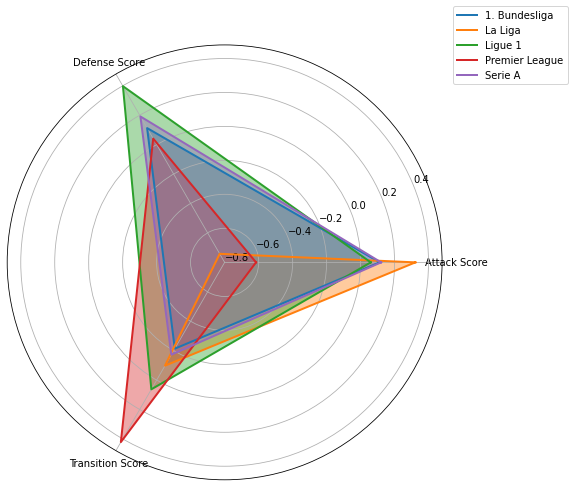

In [59]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx,row in plot_comp_agg.iterrows():
    radar_chart(ax, categories, list(row.values), idx)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# ax.set_title('League Comparison', va='bottom')

## Individual attribute comparison

### Attack

In [61]:
categories = ['avg_Attacking_pass_count','avg_Forward_carry_count','avg_Attacking_foul_count','avg_goal_count',
             'avg_total_offside_count']

In [62]:
plot_at_comp_agg = pd_comp_agg.set_index('competition_competition_name')[attack_cols]
plot_at_comp_agg.head()

,avg_Attacking_avg_pass_distance,avg_Attacking_pass_count,avg_Forward_carry_count,avg_Forward_avg_carry_distance,avg_Forward_avg_attacking_carry_distance,avg_Attacking_foul_count,avg_Attacking_foul_share,avg_goal_count,avg_total_offside_count
competition_competition_name,,,,,,,,,
1. Bundesliga,22.304641,234.629085,201.044118,7.867876,7.867876,1.978517,0.126326,1.367647,2.464052
La Liga,21.875724,233.255263,199.500000,8.079319,8.079319,2.564715,0.150049,1.335740,2.453947
Ligue 1,21.487044,242.553663,212.935562,8.107111,8.107111,1.891390,0.118301,1.215007,2.148542
Premier League,21.767250,235.488158,199.605263,8.322711,8.322711,2.023403,0.158215,1.300000,1.960526
Serie A,21.321895,240.246053,207.785526,8.223009,8.223009,1.921304,0.113535,1.251316,2.372368


In [63]:
scaler_minmax = StandardScaler()
comp_agg_at_sc = scaler_minmax.fit_transform(plot_at_comp_agg)
pd_comp_agg_at_sc = pd.DataFrame(comp_agg_at_sc, index = plot_at_comp_agg.index,
                                        columns = plot_at_comp_agg.columns)

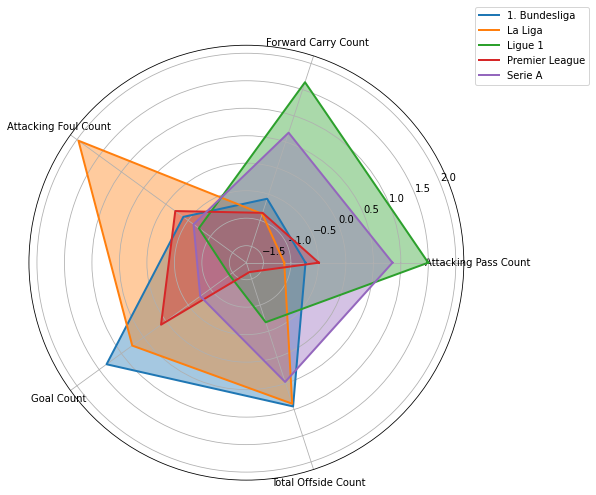

In [67]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx,row in pd_comp_agg_at_sc[categories].iterrows():
    radar_chart(ax, categories, list(row.values), idx)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

### Defense

In [81]:
categories = ['avg_duel_count', 'avg_block_count', 'avg_clearance_count', 'avg_shield_count',
              'avg_Defensive_pass_count', 'avg_Backward_carry_count',
              'avg_Defensive_foul_count']

In [82]:
plot_de_comp_agg = pd_comp_agg.set_index('competition_competition_name')[defense_cols]
plot_de_comp_agg.head()

,avg_duel_count,avg_block_count,avg_clearance_count,avg_shield_count,avg_Defensive_avg_pass_distance,avg_Defensive_pass_count,avg_Backward_carry_count,avg_Backward_avg_carry_distance,avg_Backward_avg_attacking_carry_distance,avg_Defensive_foul_count,avg_Defensive_foul_share
competition_competition_name,,,,,,,,,,,
1. Bundesliga,42.287582,20.366013,23.616013,1.435649,22.355980,238.186275,96.189542,4.701006,-4.701006,5.322084,0.307097
La Liga,41.550000,18.310526,21.338158,1.408946,21.812816,238.280263,98.644737,4.697663,-4.697663,4.230086,0.262558
Ligue 1,43.004943,19.474075,23.041038,1.441155,21.553105,244.668243,99.076849,4.717430,-4.717430,4.335025,0.287013
Premier League,42.486842,19.525000,28.480263,1.412585,21.544908,238.253947,101.589474,4.882549,-4.882549,3.274577,0.245458
Serie A,37.939474,20.693421,23.388158,1.438150,21.605145,242.938158,99.347368,4.671912,-4.671912,4.608322,0.266713


In [83]:
scaler_minmax = StandardScaler()
comp_agg_de_sc = scaler_minmax.fit_transform(plot_de_comp_agg)
pd_comp_agg_de_sc = pd.DataFrame(comp_agg_de_sc, index = plot_de_comp_agg.index,
                                        columns = plot_de_comp_agg.columns)

In [84]:
pd_comp_agg_transition_sc

,avg_duel_count,avg_block_count,avg_clearance_count,avg_shield_count,avg_Defensive_avg_pass_distance,avg_Defensive_pass_count,avg_Backward_carry_count,avg_Backward_avg_carry_distance,avg_Backward_avg_attacking_carry_distance,avg_Defensive_foul_count,avg_Defensive_foul_share
competition_competition_name,,,,,,,,,,,
1. Bundesliga,0.458608,0.834609,-0.149160,0.611487,1.896942,-0.819862,-1.613030,-0.437688,0.437688,1.465173,1.566576
La Liga,0.052929,-1.643740,-1.101648,-1.343557,0.125329,-0.786051,-0.188487,-0.481890,0.481890,-0.187573,-0.526891
Ligue 1,0.853166,-0.240821,-0.389586,1.014580,-0.721758,1.511897,0.062231,-0.220555,0.220555,-0.028747,0.622582
Premier League,0.568204,-0.179420,1.884833,-1.077113,-0.748493,-0.795518,1.520095,1.962477,-1.962477,-1.633743,-1.330659
Serie A,-1.932907,1.229373,-0.244438,0.794603,-0.552021,0.889533,0.219191,-0.822344,0.822344,0.384890,-0.331608


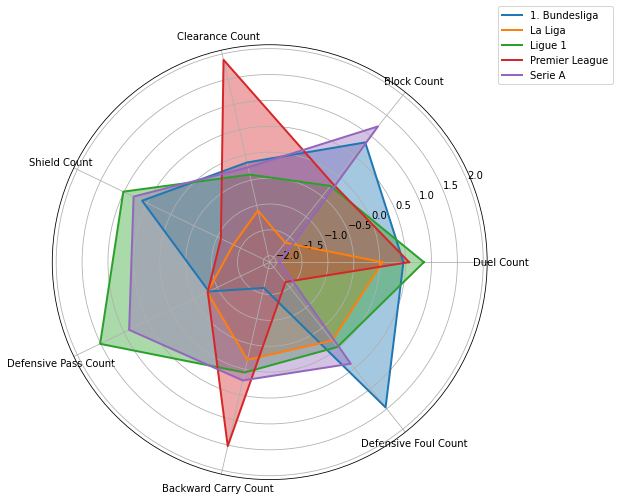

In [85]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx,row in pd_comp_agg_de_sc[categories].iterrows():
    radar_chart(ax, categories, list(row.values), idx)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# ax.set_title('League Comparison', va='bottom')

### Transition

In [90]:
categories = ['avg_ball_recovery_count', 'avg_interception_count',  
               'avg_Transition_pass_count', 'avg_Transition_carry_count', 
               'avg_Transition_foul_count']

In [91]:
plot_tr_comp_agg = pd_comp_agg[['competition_competition_name']+transition_cols]
plot_tr_comp_agg = plot_tr_comp_agg.set_index('competition_competition_name')
plot_tr_comp_agg.head()

,avg_ball_recovery_count,avg_interception_count,avg_Transition_pass_count,avg_Transition_carry_count,avg_Transition_foul_count
competition_competition_name,,,,,
1. Bundesliga,51.895425,9.769608,7.670558,4.590351,1.277097
La Liga,50.676316,16.281579,6.686365,4.556067,1.277139
Ligue 1,55.543314,11.318706,6.710862,4.587346,1.267498
Premier League,53.872368,11.736842,8.495306,4.744494,1.216975
Serie A,54.384211,10.198684,5.806467,4.536053,1.322815


In [93]:
scaler_minmax = StandardScaler()
comp_agg_tr_sc = scaler_minmax.fit_transform(plot_tr_comp_agg[categories])
pd_comp_agg_tr_sc = pd.DataFrame(comp_agg_tr_sc,index = plot_tr_comp_agg.index,
                                        columns = categories)

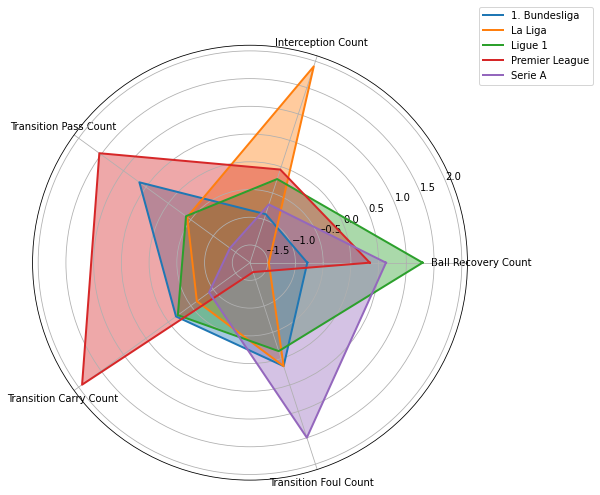

In [79]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx,row in pd_comp_agg_tr_sc[categories].iterrows():
    radar_chart(ax, categories, list(row.values), idx)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# ax.set_title('League Comparison', va='bottom')